In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from pyzx.linalg import *
import pyzx.phasepoly
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

In [234]:
qubits = 3
depth = 120
iterations = 1


for i in range(1,iterations+1):
    if i%50 == 0:
        print(i, end='.')
    seed = random.randint(0,100000)
    random.seed(seed)
    circ = zx.cliffordT(qubits, depth, p_t=0.2)
    g = circ.copy()
    #zx.clifford_simp(g,quiet=True)
#     c1 = tcount(g)
#     c = zx.extract.streaming_extract(g).to_basic_gates()
#     c, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c, optimize=True)
    #print(c.stats())
    #g = circ.copy()
    full_reduce(g)
    #c2 = tcount(g)
    try:
        c = zx.extract.streaming_extract(g).to_basic_gates()
    except Exception as e:
        zx.simplify.id_simp(g, quiet=True)
        g.normalise()
        print("Errawr", e)
        break
#         g2 = g.adjoint()
#         try:
#             c = zx.extract.streaming_extract(g2).to_basic_gates()
#         except ValueError:
#             zx.simplify.id_simp(g2, quiet=True)
#             g2.normalise()
        if g.depth()>4 and g.depth()<20:
            left = [v for v in g.vertices() if g.row(v)==1]
            right = set()
            for v in left: right.update(w for w in g.neighbours(v) if g.row(w)>1)
            if len(right)>4:
                print("Errawr")
                break
    #c, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c, optimize=True)
    #print(c.stats())
    #print("tcount: {!s} vs {!s}".format(c1,c2))
#     if not zx.compare_tensors(circ.to_tensor(),c.to_tensor()):
#         raise Exception


Complicated phase gadget
Errawr Not fully reduced on vertex 11


In [235]:
seed

67735

In [236]:
qubits = 3
depth = 120
#seed = 76072 # easier
seed = 67735
#depth = 60
#seed = 154
# qubits = 3
# depth = 30
# seed = 42950 #Exception on this one
random.seed(seed)
circ = zx.cliffordT(qubits, depth, p_t=0.2)
#zx.draw(circ,figsize=(25,1))

Complicated phase gadget


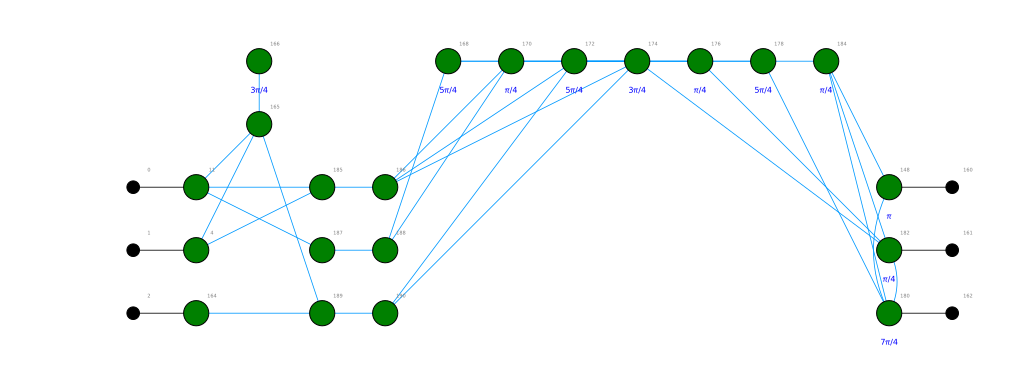

In [240]:
g = circ.copy()
full_reduce(g)
g.normalise()
try: c = zx.extract.streaming_extract(g,stopcount=-1)
except Exception as e: print(e)
#zx.simplify.id_simp(g, quiet=True)
#g.normalise()
# g = g.adjoint()
# try: c = zx.extract.streaming_extract(g,stopcount=-1).to_basic_gates()
# except ValueError: pass
# zx.simplify.id_simp(g, quiet=True)
# g.normalise()
g2 = g.copy()
# g2.set_phase(10,0)
# g2.set_phase(2,0)
# g2.set_phase(9,0)
# # g2.set_qubit(12,-1.2)
# # g2.set_qubit(7,-1.2)
# g2.set_position(12,0,3)
# g2.set_position(15,1,3)
# g2.set_position(16,2,3)
# # g2.remove_vertices([5,6,2,7])
# g2.remove_edges([(5,9), (10,2), (10,5),(10,6)])
# g2.add_edges([(5,6)],2)
# g2.set_edge_type((10,3),2)
# g2.set_edge_type((2,4),2)

zx.draw(g, labels=True, figsize=(14,5))

In [196]:
zx.compare_tensors(circ.to_tensor(), c.to_tensor())

True

In [243]:
from pyzx.extract import cut_rank, cut_edges, bi_adj
from pyzx.circuit import ParityPhase, CNOT, HAD, ZPhase, CZ
def handle_phase_gadget(g, leftrow):
    q = g.qubit_count()
    qs = g.qubits() # We are assuming this thing automatically updates
    rs = g.rows()
    special_nodes = {}
    left = []
    for v in g.vertices():
        if len(list(g.neighbours(v))) == 1 and v not in g.inputs and v not in g.outputs:
            n = list(g.neighbours(v))[0]
            special_nodes[n] = v
        if rs[v] == leftrow: left.append(v)
    
    neigh = set()
    for v in left: neigh.update(w for w in g.neighbours(v) if rs[w]>leftrow)
    gadgets = neigh.intersection(special_nodes) # These are the phase gadgets that are attached to the left row
    if len(gadgets) == 0: raise ValueError("No phase gadget connected to this row")
    for gadget in gadgets:
        right = list(neigh.difference({gadget}))
        if cut_rank(g, right, left + [gadget]) == q: # A good choice should allow us to cut the edges
            break
    else:
        raise ValueError("No good cut for phase gadget found")
    g.set_row(gadget,leftrow+1)
    g.set_row(special_nodes[gadget],leftrow+1)
    if len(right) == q:
        print("No cutting necessary")
        for w in right:
            g.set_row(w, leftrow+2)
    else:
        right = cut_edges(g, left+[gadget], right)
    # We have now prepared the stage to do the extraction of the phase gadget
    
    left.sort(key=g.qubit)
    right.sort(key=g.qubit)
    gadget_left = [v for v in left if g.connected(gadget, v)]
    gadget_right = [w for w in right if g.connected(gadget, w)]
    if not gadget_right or not gadget_left: #Only connected on leftside or rightside, so we are almost done
        print("Simple phase gadget")
        targets = gadget_left if not gadget_right else gadget_right
        phase = g.phase(special_nodes[gadget])
        gate = ParityPhase(phase, *targets)
        g.remove_vertices([special_nodes[gadget],gadget])
        if not gadget_right: # ParityPhase is on left side
            return [gate]
        m = bi_adj(g, right, left) # ParityPhase on the right side, which means we have to 
        gates = m.to_cnots(optimize=True) # reduce everything before it to cnots
        gates.append(gate)
        for i in range(q):
            for j in range(q):
                if i ==j:
                    if not g.connected(left[i], right[j]):
                        g.add_edge((left[i],right[j]), 2)
                else:
                    if g.connected(left[i],right[j]):
                        g.remove_edge((left[i],right[j]))
        return gates
    print("Complicated phase gadget") # targets on left and right, so need to do more preparation
    gates = []
    m = bi_adj(g, right, left)
    print(m,'.')
    return
    left_options = [v for v in left if any(g.connected(v,w) for w in gadget_right)]
    print("left_options", left_options)
    if len(gadget_left) > 2:
        raise Exception("Too many on the left. Not supported yet")
    if len(gadget_left) == 1: # We need additional connectivity
        v1 = gadget_left[0]
        options = set(left_options).difference({v1})
        if not options:
            raise Exception("Not supported yet")
        v2 = options.pop()
        gates.append(CNOT(qs[v2],qs[v1]))
        m.row_add(qs[v1],qs[v2])
        g.add_edge((v2,gadget),2)
        #print(m,'.')
        gadget_left.append(v2)
    
    right_options = [w for w in right if any(g.connected(w,v) for v in gadget_left)]
    gatesright = []
    if len(gadget_right) > 2:
        raise Exception("Too many on the right. Not supported yet")
    if len(gadget_right) == 1:
        w1 = gadget_right[0]
        options = set(right_options).difference({w1})
        if not options:
            raise Exception("Not supported yet")
        w2 = options.pop()
        gatesright.append(CNOT(qs[w2],qs[w1])) # This gate needs to come after all the other gates we extracct
        m.col_add(qs[w1],qs[w2])
        g.add_edge((w2,gadget),2)
        gadget_right.append(w2)
        #print(m)
        
    for i in range(q):
        for j in range(q):
            if m.data[i][j] and not g.connected(left[i],right[j]):
                g.add_edge((left[i],right[j]),2)
            elif not m.data[i][j] and g.connected(left[i],right[j]):
                g.remove_edge((left[i],right[j]))
    
    # We now need to move the vertices on the right that are connected to
    # the phase gadget to the corresponding qubits of the left side
    displaced_verts = set()
    locations = set()
    for v in gadget_left:
        if sum(m.data[qs[v]]) != 1:
            raise Exception("Not fully reduced on vertex ", v)
        w = next(w for w in gadget_right if g.connected(v,w))
        if qs[w] != qs[v]: # We need to move w to the qubit position of v
            if qs[v] in locations:
                locations.remove(qs[v])
            else:
                w2 = right[qs[v]] # the vertex that is in the way
                if w2 not in gadget_right:
                    displaced_verts.add(w2)
            locations.add(qs[w])
            g.set_qubit(w, qs[v])
        g.set_edge_type((v,w),1)
    for w in displaced_verts: # Move vertices whose qubit location was dibsed to other location
        g.set_qubit(w, locations.pop())
    
    #Now we can finally extract the phase gadget
    targets = [qs[v] for v in gadget_left]
    for t in targets: 
        gates.extend([HAD(t),ZPhase(t,Fraction(-1,2)),HAD(t)])
    phase = g.phase(special_nodes[gadget])
    gates.append(ParityPhase(-phase, *targets))
    for t in targets:
        gates.extend([HAD(t),ZPhase(t, Fraction(1,2))])
    # There might be some connectivity between things on the left and on the right that we
    # need to take care of
    for w in gadget_right:
        conn = [v for v in left if v not in gadget_left and g.connected(v,w)]
        for v in conn:
            gates.append(CZ(qs[w], qs[v]))
        g.remove_edges([(v,w) for v in conn])
        g.set_row(w, leftrow+1)
#     left = [v for v in left if v not in gadget_left]
#     right = [w for w in right if w not in gadget_right]
#     left.sort(key=g.qubit)
#     right.sort(key=g.qubit)
#     qmap = [qs[v] for v in left]
#     m = bi_adj(g, left, right)
#     for cnot in m.to_cnots():
#         cnot.control = qmap[cnot.control]
#         cnot.target = qmap[cnot.target]
#         gates.append(cnot)
#     for t in qmap:
#         gates.append(HAD(t))
#     for w in right:
#         g.set_row(w, leftrow+1)
#         for v in left:
#             if g.connected(v,w):
#                 if qs[v] != qs[w]:
#                     g.remove_edge((v,w))
#                 else:
#                     g.set_edge_type((v,w),1)
#             elif qs[v] == qs[w]:
#                     g.add_edge((v,w),1)
    
    for v in left:
        if v in gadget_left: continue
        g.set_row(v, leftrow+1)
    for gate in gatesright: # And finally we can add the gates on the rightside, taking care to change their qubit locations
        gate.target = qs[right[gate.target]]
        gate.control = qs[right[gate.control]]
        gates.append(gate)
    
    g.remove_vertices([special_nodes[gadget],gadget])
    
    return gates

g3 = g.copy()
handle_phase_gadget(g3, 1)
# c = zx.Circuit(g.qubit_count())
# c.gates = handle_phase_gadget(g3, 1)
# cg = c.to_graph()
# cg.compose(g3)

# zx.compare_tensors(g2.to_tensor(),cg.to_tensor())

No cutting necessary
Complicated phase gadget
[ 1  1  0 ]
[ 1  0  0 ]
[ 0  0  1 ] .


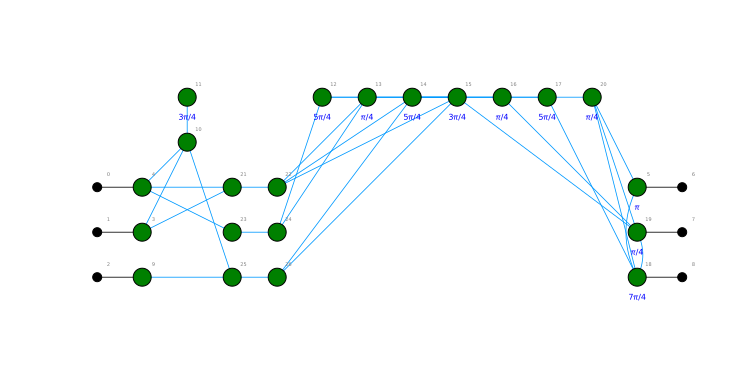

In [242]:
zx.draw(g3,labels=True,figsize=(10,5))

In [119]:
adj = g3.adjoint()
adj.compose(g3)
zx.compare_tensors(adj.to_tensor(),zx.generate.identity(g.qubit_count()).to_tensor())

True

In [75]:
t = g2.to_tensor()
t/t.flatten()[0]

array([[[[ 1.+0.j        , -0.+0.41421356j],
         [ 1.+0.j        , -0.+0.41421356j]],

        [[ 1.+0.j        ,  0.-0.41421356j],
         [-1.-0.j        , -0.+0.41421356j]]],


       [[[-0.+0.41421356j,  1.+0.j        ],
         [ 0.-0.41421356j, -1.-0.j        ]],

        [[ 0.-0.41421356j,  1.+0.j        ],
         [ 0.-0.41421356j,  1.+0.j        ]]]])

In [77]:
def paccept(r):
    return (random.random() < r)

def circuit_generator(g, limit=6):
    t = g.to_tensor()
    q = g.qubit_count()
    while True:
        c = zx.Circuit(q)
        amount = random.randint(2, limit)
        for g in range(amount):
            target = random.randint(0,q-1)
            
            if paccept(0.2):
                denom = 2**random.randint(0,1)
                numer = random.randint(1,2*denom-1)
                if paccept(0.5): c.add_gate("ZPhase", target, Fraction(numer,denom))
                else: c.add_gate("XPhase", target, Fraction(numer,denom))
            elif paccept(0.2):
                c.add_gate("HAD",target)
            else:
                control = random.randint(0,q-1)
                while control == target: control = random.randint(0,q-1)
                if paccept(0.5):
                    c.add_gate("CNOT", control, target)
                else:
                    numer = 1 + 2*random.randint(0,3)
                    c.add_gate("ParityPhase", Fraction(numer,4), control, target)
        if zx.compare_tensors(c.to_tensor(), t):
            return c

c = circuit_generator(g2,6)
zx.draw(c.to_graph())

KeyboardInterrupt: 

In [188]:
g = g2.copy()
from pyzx.extract import bi_adj, cut_rank
rs = g.rows()
q = g.qubit_count()
leftrow = 1
left = [v for v in g.vertices() if rs[v] == leftrow]
left.sort(key=g.qubit)
right = set()
for v in left:
    d = [w for w in g.neighbours(v) if rs[w]>leftrow]
    right.update(d)

special_nodes = {}
for v in g.vertices():
    if len(list(g.neighbours(v))) == 1 and v not in g.inputs and v not in g.outputs:
        n = list(g.neighbours(v))[0]
        special_nodes[n] = v
#right.difference_update(special_nodes)
#right = list(right)
for w in right:
    other = right.difference([w])
    if cut_rank(g, other, left) == q-1:
        break
    print(w, cut_rank(g, other,left))
else:
    print("Error")
# import random
# while True:
#     selection = random.sample(right, q)
#     m = bi_adj(g,selection,left)
#     if m.rank() == q:
#         break
# other = right.difference(selection)
#m = bi_adj(g,right,left)
#cut_rank(g,right, left)

10 3
5 3
6 3
7 3
Error


In [187]:
left, right, w, other

([3, 12, 4], {5, 6, 7}, 5, {6, 7})

In [52]:
from pyzx.extract import cut_edges, unspider
#g2 = g
#g = g.copy()
available = list(range(q))
for v in left:
    if g.connected(v,w):
        g.set_qubit(w, g.qubit(v))
        available.remove(g.qubit(v))
        break
cut_edges(g, left, list(other), available)
g.set_row(w, leftrow+2)
unspider(g,w)

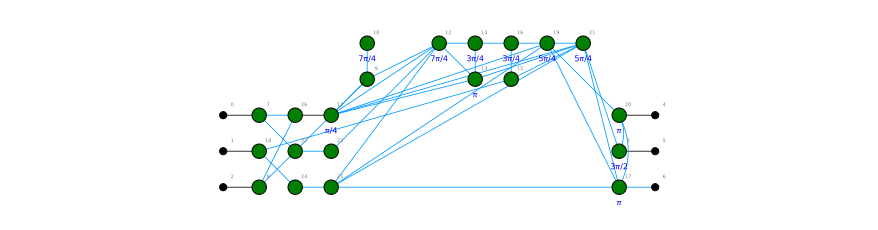

In [53]:
zx.draw(g,labels=True,figsize=(12,3))

In [54]:
right = set()
for v in left:
    d = [w for w in g.neighbours(v) if rs[w]>leftrow]
    right.update(d)
right = list(right)
m = bi_adj(g, right, left)
m, left, right

([ 0  0  1  1  0 ]
 [ 1  0  0  0  1 ]
 [ 0  1  1  0  0 ], [7, 18, 8], [24, 9, 26, 22, 15])

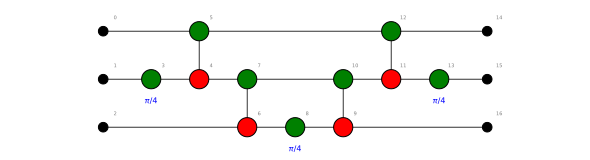

In [135]:
c = zx.Circuit(3)
c.add_gate("T",1)
c.add_gate("ParityPhase",Fraction(1,4),0,1,2)
# c.add_gate("CNOT",0,1)
# c.add_gate("T",1)
# c.add_gate("CNOT",0,1)
c.add_gate("T",1)
g = c.to_graph()
zx.draw(g,labels=True)

spider_simp: 1.  1 iterations
Gadgetizing...
pivot_simp: 2. 1.  2 iterations
pivot_simp: 1.  1 iterations
id_simp: 3.  1 iterations
spider_simp: 1.  1 iterations
1


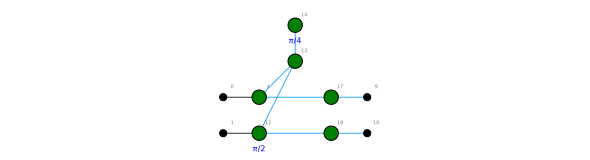

In [8]:
g = c.to_graph()
full_reduce(g,quiet=False)
print(tcount(g))
# for v in g.vertices():
#     q = g.qubit(v)
#     if q < 0: 
#         g.set_qubit(v, -q-1)
#         g.set_row(v, g.row(v)+0.5)
g.normalise()

zx.draw(g,labels=True)

In [9]:
c2 = zx.extract.streaming_extract(g).to_basic_gates()
print(c2.gates)

[ZPhase(1,phase=1/2), CNOT(1,0), ZPhase(0,phase=1/4), CNOT(1,0), HAD(0), HAD(1), HAD(0), HAD(1)]


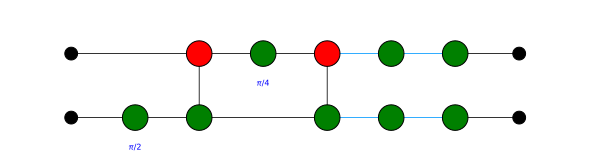

In [10]:
zx.draw(c2.to_graph())

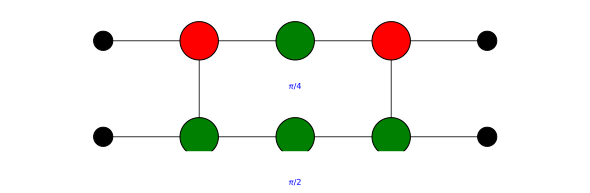

In [13]:
import pyzx.phasepoly
c3, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c2)
zx.draw(c3.to_graph())

In [44]:
while True:
    edges = [e for e in g.edges() if e not in es]
    print(edges)
    m = zx.rules.match_pivot_parallel(g, check_edge_types=True,edgelist=edges)
    if not m: break
    etab, rem_verts, rem_edges, check_isolated_vertices = zx.rules.pivot(g, m)
    g.add_edge_table(etab)
    g.remove_edges(rem_edges)
    g.remove_vertices(rem_verts)
    if check_isolated_vertices: g.remove_isolated_vertices()
zx.simplify.id_simp(g,quiet=True)
zx.simplify.spider_simp(g,quiet=True)
zx.simplify.id_simp(g,quiet=True)
g.normalise()
zx.draw(g)

NameError: name 'es' is not defined

In [3]:
def gadgetize(g):
    phases = g.phases()
    #qs = g.qubits()
    rs = g.rows()
    edges = []
    for v in list(g.vertices()):
        if phases[v] != 0 and phases[v].denominator > 2:
            v1 = g.add_vertex(1,-1,rs[v]+0.5,0)
            v2 = g.add_vertex(1,-2,rs[v]+0.5,phases[v])
            g.set_phase(v, 0)
            edges.append((v,v1))
            edges.append((v1,v2))
    g.add_edges(edges, 2)
    return edges

In [59]:
def full_reduce(g, quiet=True):
    zx.simplify.clifford_simp(g,quiet=quiet)
    if not quiet: print("Gadgetizing...")
    es = gadgetize(g)
    edges = [e for e in g.edges() if e not in es]
    zx.simplify.pivot_simp(g,matchset=edges,quiet=quiet)
    zx.simplify.lcomp_simp(g, quiet=quiet)
    edges = [e for e in g.edges() if e not in es]
    zx.simplify.pivot_simp(g,matchset=edges,quiet=quiet)
    phases = g.phases()
    for v in g.vertices():
        if phases[v] != 0 and phases[v].denominator > 2 and len(list(g.neighbours(v)))==1:
            n = list(g.neighbours(v))[0]
            if phases[n] == 1:
                g.set_phase(n, 0)
                g.set_phase(v, -1*phases[v])
                phases[n] = 0
    zx.simplify.clifford_simp(g,quiet=quiet)

In [5]:
def tcount(g):
    count = 0
    phases = g.phases()
    for v in g.vertices():
        if phases[v]!=0 and phases[v].denominator > 2:
            count += 1
    return count

In [7]:
import os
f = os.path.abspath("../circuits/Arithmetic_and_Toffoli/barenco_tof_4_before")
c = zx.Circuit.from_quipper_file(f)
g = c.to_graph()
full_reduce(g,quiet=False)
g.normalise()
#zx.draw(g, figsize=(25,4))
#zx.simplify.clifford_simp(g)
print(tcount(g))
#g.normalise()
#zx.draw(g)
c2 = zx.extract.streaming_extract(g)
print(len(c2.gates))
g = c2.to_graph()
zx.simplify.to_gh(g)
zx.simplify.id_simp(g,quiet=True)
c3 = zx.Circuit.from_graph(g, split_phases=False)
print(len(c3.gates))
import pyzx.phasepoly
c3, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c3, optimize=True)
print(c3.stats())

spider_simp: 19. 17. 10. 4. 3. 2. 1.  7 iterations
spider_simp: 4.  1 iterations
pivot_simp: 13. 1.  2 iterations
id_simp: 2.  1 iterations
Gadgetizing...
pivot_simp: 25. 8. 5. 1. 1.  5 iterations
pivot_simp: 7. 3. 4.  3 iterations
id_simp: 6.  1 iterations
spider_simp: 3. 1.  2 iterations
40
103
277
Circuit on 7 qubits with 129 gates.
        30 T-like gates
        99 Cliffords among which 
        65 2-qubit gates and 22 Hadamard gates.


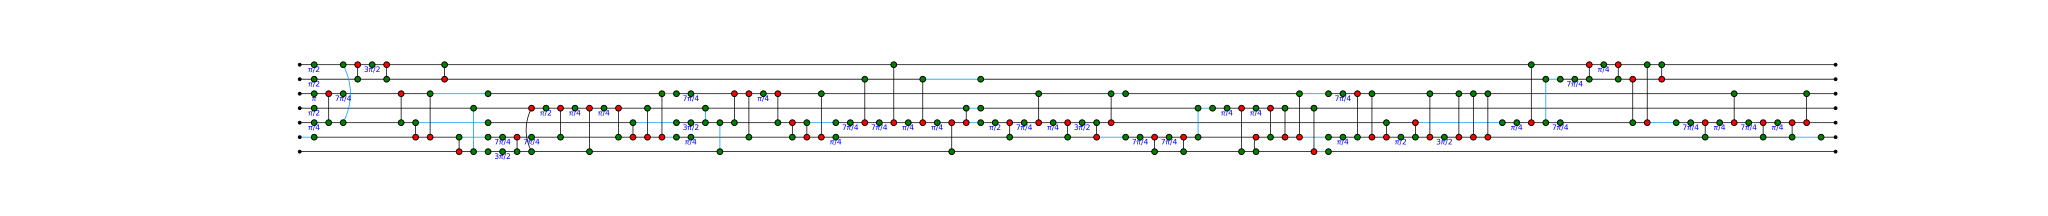

In [8]:
zx.draw(c3.to_graph(), figsize=(30,3))

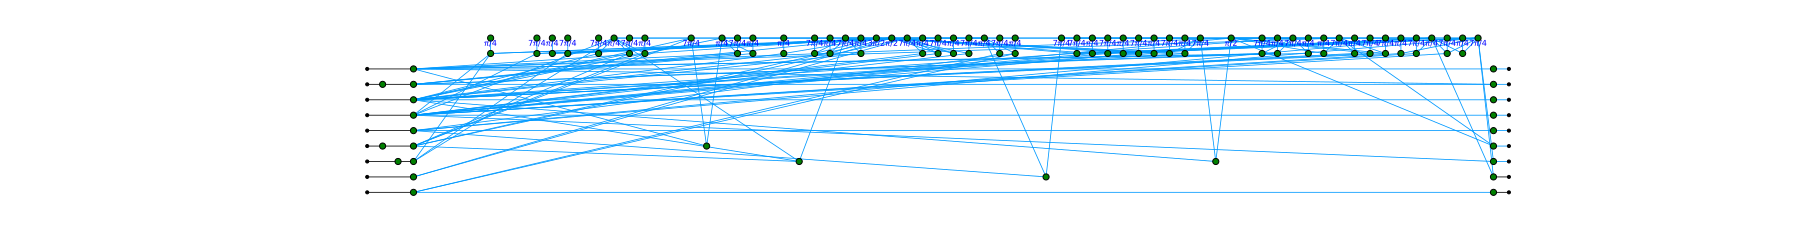

In [12]:
zx.draw(g, figsize=(25,3))